In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
train_dir = './train/no_contrast'

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    validation_split=0.25) #수평방향 뒤집기

Using TensorFlow backend.


In [4]:
train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(224,224),
        batch_size=32,
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(224,224),
    batch_size=32,
    subset='validation') # set as validation data

Found 2148 images belonging to 6 classes.
Found 713 images belonging to 6 classes.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
for layer in model.layers:
    layer.trainable=False

x=model.output
x=layers.Flatten()(x)
outputs=Dense(4, activation='softmax')(x)

additional_model=Model(inputs=model.input, outputs=outputs)

additional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_참고문헌_no_hist.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=3,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
    callbacks=[checkpoint])

Epoch 1/3
54/53 [==============================] - 26s 481ms/step - loss: 6.6999 - acc: 0.3751 - auc: 0.5723 - precision: 0.3141 - recall: 0.3099 - f1score: nan - val_loss: 7.8712 - val_acc: 0.4158 - val_auc: 0.6261 - val_precision: 0.3792 - val_recall: 0.3752 - val_f1score: 0.1117
Epoch 2/3
54/53 [==============================] - 20s 373ms/step - loss: 4.4225 - acc: 0.4895 - auc: 0.6534 - precision: 0.4136 - recall: 0.4092 - f1score: nan - val_loss: 3.4670 - val_acc: 0.4842 - val_auc: 0.6692 - val_precision: 0.4351 - val_recall: 0.4300 - val_f1score: 0.1301
Epoch 3/3
54/53 [==============================] - 22s 400ms/step - loss: 3.7200 - acc: 0.5368 - auc: 0.6841 - precision: 0.4538 - recall: 0.4483 - f1score: nan - val_loss: 5.0363 - val_acc: 0.5000 - val_auc: 0.6958 - val_precision: 0.4681 - val_recall: 0.4623 - val_f1score: 0.1334


In [11]:
for layer in additional_model.layers[:11]:
    layer.trainable=False

for layer in additional_model.layers[11:]:
    layer.trainable=True

In [12]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x000002CD2B987A08> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2B997508> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2B997F88> False
<keras.layers.pooling.MaxPooling2D object at 0x000002CD2BB71188> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2BB71E48> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2BB7BE48> False
<keras.layers.pooling.MaxPooling2D object at 0x000002CD2BB7F3C8> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2BB7F248> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2BB88B48> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2BBE34C8> False
<keras.layers.pooling.MaxPooling2D object at 0x000002CD2BBEA4C8> False
<keras.layers.convolutional.Conv2D object at 0x000002CD2BBEA088> True
<keras.layers.convolutional.Conv2D object at 0x000002CD2BBF2648> True
<keras.layers.convolutional.Conv2D object at 0x000002CD2BBF6588> True
<keras.

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [13]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [14]:
history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=10,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
    callbacks=[checkpoint])

Epoch 1/10
54/53 [==============================] - 23s 433ms/step - loss: 1.5445 - acc: 0.3921 - auc_1: 0.6725 - precision_1: 0.4658 - recall_1: 0.2991 - f1score: nan - val_loss: 1.2778 - val_acc: 0.4351 - val_auc_1: 0.6882 - val_precision_1: 0.4840 - val_recall_1: 0.2381 - val_f1score: 0.1255
Epoch 2/10
54/53 [==============================] - 22s 405ms/step - loss: 1.0678 - acc: 0.4866 - auc_1: 0.7130 - precision_1: 0.4999 - recall_1: 0.2406 - f1score: 0.1377 - val_loss: 1.3018 - val_acc: 0.4982 - val_auc_1: 0.7402 - val_precision_1: 0.5206 - val_recall_1: 0.2737 - val_f1score: 0.1416
Epoch 3/10
54/53 [==============================] - 22s 402ms/step - loss: 0.9919 - acc: 0.5420 - auc_1: 0.7553 - precision_1: 0.5393 - recall_1: 0.3006 - f1score: 0.1467 - val_loss: 0.9093 - val_acc: 0.5140 - val_auc_1: 0.7677 - val_precision_1: 0.5559 - val_recall_1: 0.3190 - val_f1score: 0.1417
Epoch 4/10
54/53 [==============================] - 22s 401ms/step - loss: 0.9361 - acc: 0.5712 - auc_1: 0

In [15]:
for layer in additional_model.layers:
    layer.trainable=True

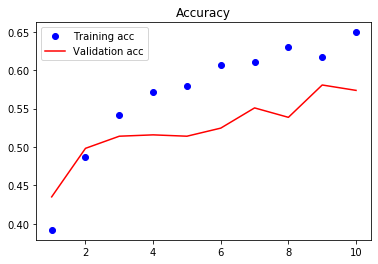

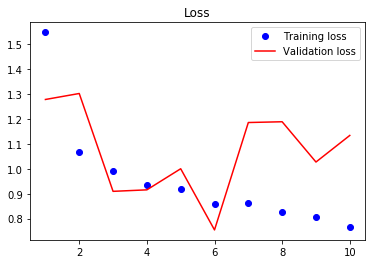

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [17]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=37,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
    callbacks=[checkpoint])

Epoch 1/37
54/53 [==============================] - 26s 473ms/step - loss: 0.7105 - acc: 0.6814 - auc: 0.9042 - precision_2: 0.7182 - recall_2: 0.6176 - f1score: 0.1732 - val_loss: 0.7220 - val_acc: 0.5877 - val_auc: 0.9012 - val_precision_2: 0.7135 - val_recall_2: 0.6089 - val_f1score: 0.1595
Epoch 2/37
54/53 [==============================] - 21s 387ms/step - loss: 0.6964 - acc: 0.6826 - auc: 0.9007 - precision_2: 0.7129 - recall_2: 0.6085 - f1score: 0.1751 - val_loss: 1.0878 - val_acc: 0.5825 - val_auc: 0.8992 - val_precision_2: 0.7091 - val_recall_2: 0.6065 - val_f1score: 0.1592
Epoch 3/37
54/53 [==============================] - 21s 387ms/step - loss: 0.6706 - acc: 0.7060 - auc: 0.8997 - precision_2: 0.7096 - recall_2: 0.6093 - f1score: 0.1777 - val_loss: 0.7593 - val_acc: 0.6140 - val_auc: 0.8999 - val_precision_2: 0.7101 - val_recall_2: 0.6097 - val_f1score: 0.1611
Epoch 4/37
54/53 [==============================] - 21s 389ms/step - loss: 0.6427 - acc: 0.7165 - auc: 0.9019 - pre

Epoch 29/37
54/53 [==============================] - 21s 384ms/step - loss: 0.3519 - acc: 0.8571 - auc: 0.9307 - precision_2: 0.7663 - recall_2: 0.7083 - f1score: 0.2123 - val_loss: 0.9824 - val_acc: 0.6263 - val_auc: 0.9311 - val_precision_2: 0.7670 - val_recall_2: 0.7095 - val_f1score: 0.1662
Epoch 30/37
54/53 [==============================] - 21s 383ms/step - loss: 0.3238 - acc: 0.8646 - auc: 0.9316 - precision_2: 0.7682 - recall_2: 0.7111 - f1score: 0.2148 - val_loss: 1.1972 - val_acc: 0.6105 - val_auc: 0.9319 - val_precision_2: 0.7690 - val_recall_2: 0.7123 - val_f1score: 0.1625
Epoch 31/37
54/53 [==============================] - 21s 382ms/step - loss: 0.3079 - acc: 0.8728 - auc: 0.9324 - precision_2: 0.7700 - recall_2: 0.7137 - f1score: nan - val_loss: 1.2095 - val_acc: 0.6070 - val_auc: 0.9328 - val_precision_2: 0.7709 - val_recall_2: 0.7151 - val_f1score: 0.1634
Epoch 32/37
54/53 [==============================] - 21s 388ms/step - loss: 0.3140 - acc: 0.8676 - auc: 0.9331 - pr

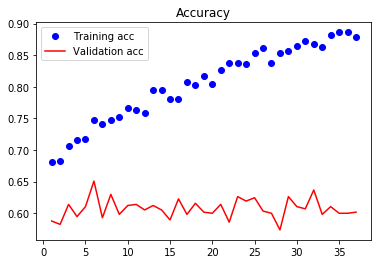

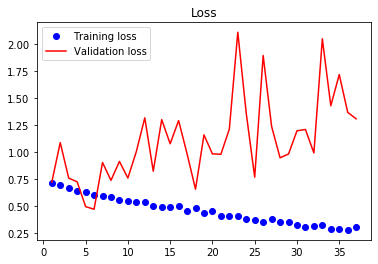

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [18]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [22]:
_loss, _acc, _auc, _precision, _recall, _f1score  = additional_model.evaluate_generator(validation_generator, steps=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

loss: 1.592, accuracy: 0.603, auc: 0.934, precision: 0.776, recall: 0.726, f1score: 0.162


In [21]:
additional_model.save('VGG16_참고문헌_no_hist_1.h5')

In [1]:
from sklearn.metrics import roc_auc_score

y_pred = additional_model.predict(X_val)
roc_auc_score(y_val, y_pred)

NameError: name 'additional_model' is not defined